**Colab 7: Graph networks**

This should be fun.  As opposed to the rigidly structured data we've been working with up to now (images on the cartesian grid, sentences as temporal sequences), we're going to lighten up a bunch and allow arbitrary connections between inputs in the form of graphs, and no connections at all in the form of sets.  The neural networks are pretty simple at the end of the day, so it's really not bad to jump right in.  We'll try to predict some sort of bio activity of molecules, using more and more information about the graph.  

First we'll start with just the information available per atom, without any connectivity information, by treating the atoms as a set.  Next we'll incorporate the connectivity and make a little graph convolutional network (GCN).  Finally we'll incorporate information about each edge (details about the bonds, provided with the dataset) and do a two-stage message passing scheme, used recently by DeepMind to learn an aspect of glassy dynamics.

FYI I was getting this to run almost 10x faster w CPU instead of GPU, probably because we're not using big tensors, and not even batching

In [ ]:
!pip install tfds-nightly
!pip install pandas
import tensorflow_datasets as tfds
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.ndimage as nim
tfkl = tf.keras.layers

In [ ]:
# The only graph dataset currently on tensorflow datasets; good enough to get our proverbial toes wet
dset = tfds.load('ogbg_molpcba')

In [ ]:
dset_train = dset['train']
dset_test = dset['test']
dset_validation = dset['validation']

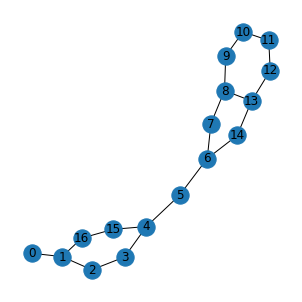

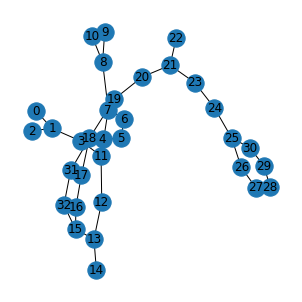

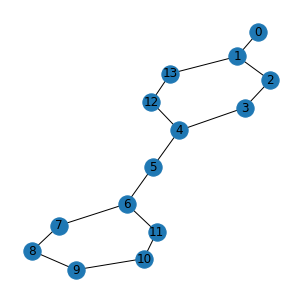

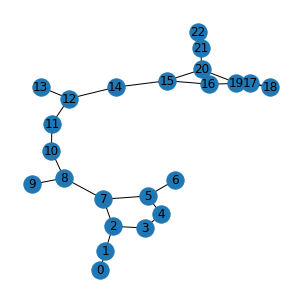

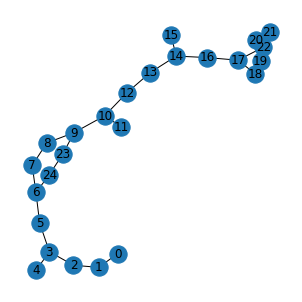

In [ ]:
# Let's do a little data inspection before we dive into the ML
# First just display some of the molecules in a barebones fashion
for graph_stuff in dset_train.take(5):
  edge_list = graph_stuff['edge_index'].numpy().tolist()
  G = nx.Graph(edge_list)
  plt.figure(figsize=(4, 4))
  nx.draw(G, with_labels=True)
  
  plt.show()

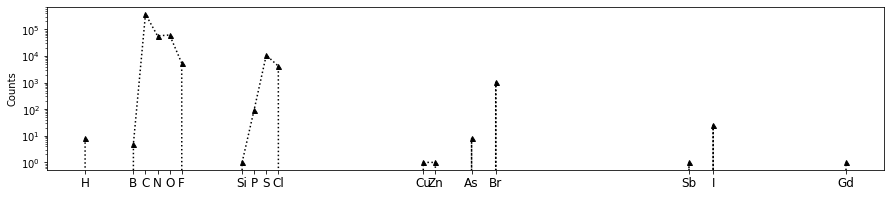

In [ ]:
# Let's get the element types for a sampling and use these for coloring
elems = ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']
atoms = []
for graph_stuff in dset_train.take(20_000):
  atomic_numbers = graph_stuff['node_feat'].numpy()[:, 0]
  atoms.append(atomic_numbers)
atoms = np.int32(np.concatenate(atoms, 0))
counts = np.bincount(atoms)
unique_elements = np.unique(atoms)
plt.figure(figsize=(15, 3))
plt.plot(counts, 'k^', markersize=5, ls=':')
plt.yscale('log')
plt.xticks(unique_elements, [elems[i] for i in unique_elements], fontsize=12)
plt.ylabel('Counts', fontsize=15)
plt.show()

[ 5  7  6 15  8 16 34 14 52  0 32  4 13 28 29 50 63]


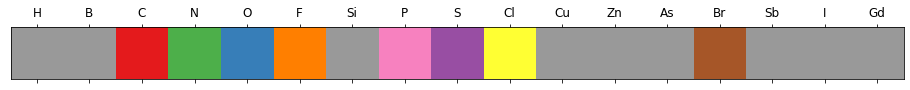

In [ ]:
# Let's color the nodes in our display by atomic number, giving colors to only the most common elements and gray for everything else
unique_counts = counts[counts>0]
sorted_elements = np.argsort(unique_counts)[::-1]  # Give the most probable ones their own bin and leave the last bin for everything else
sorted_element_ids = np.where(counts>0)[0][sorted_elements]
print(sorted_element_ids)
elem_colors = [sorted_elements.tolist().index(i) for i in range(len(sorted_elements))]
# Color the 8 most common elements and use gray for all the rest
plt.matshow([elem_colors], cmap='Set1', vmin=0, vmax=8)
plt.xticks(range(unique_elements.shape[0]), [elems[i] for i in unique_elements], fontsize=12)
plt.yticks([])
plt.show()

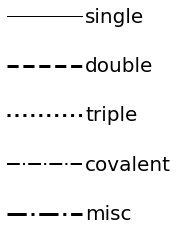

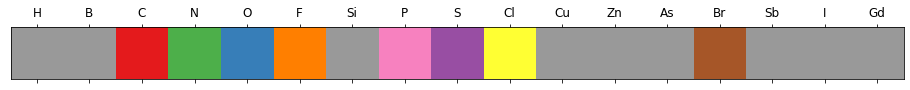

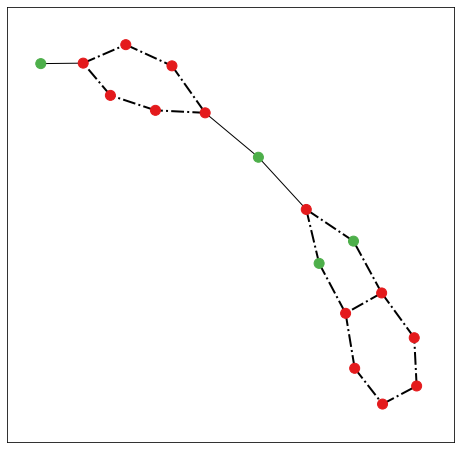

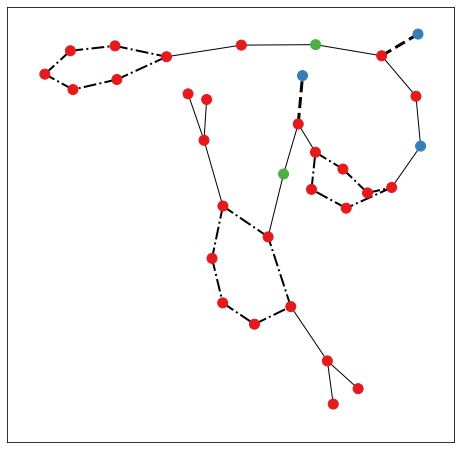

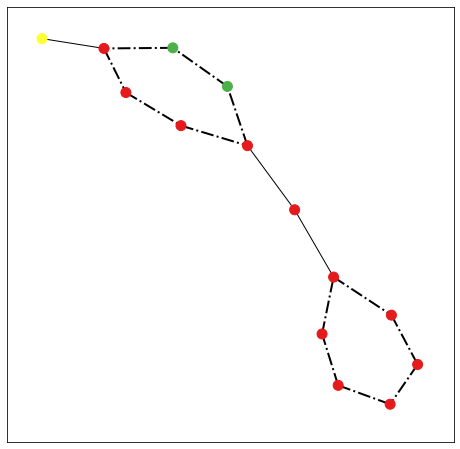

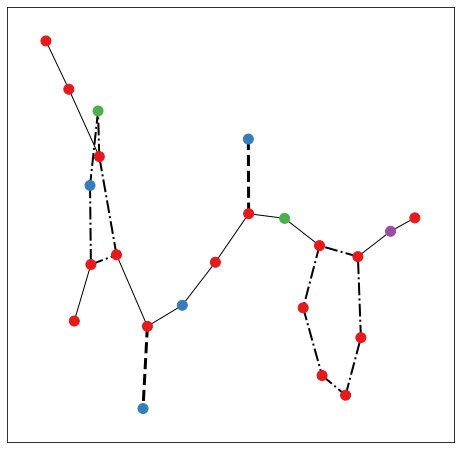

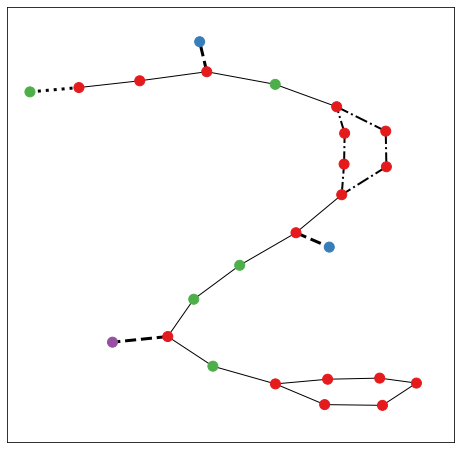

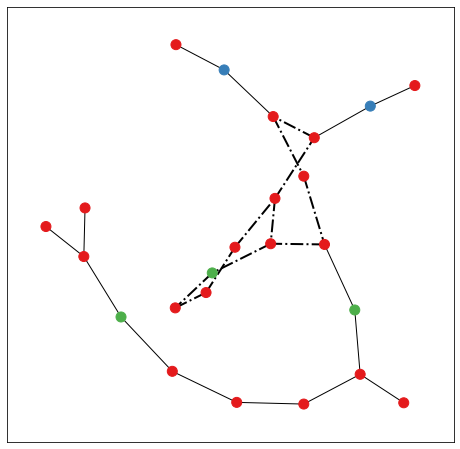

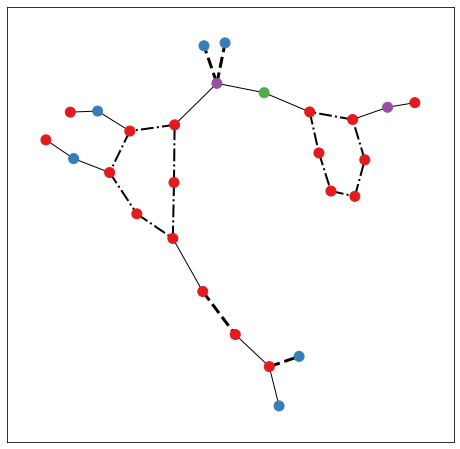

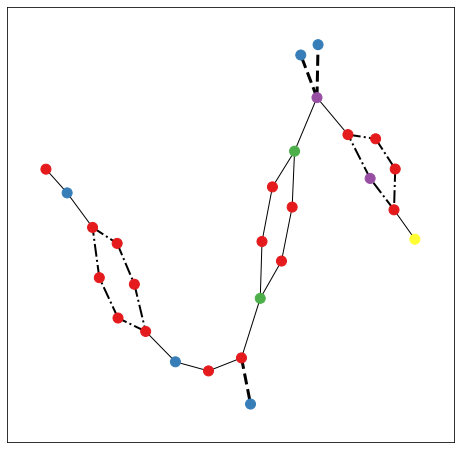

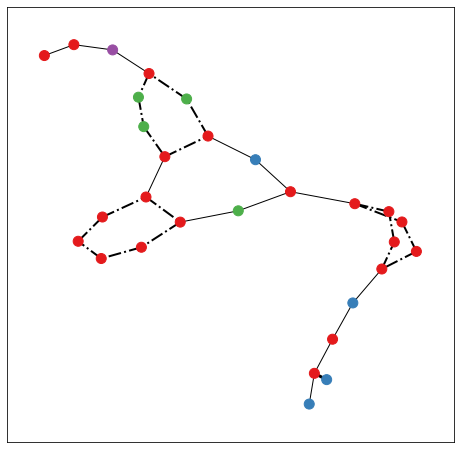

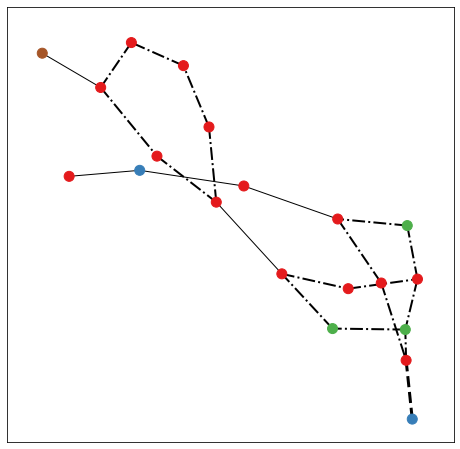

In [ ]:
# We can make this look a little more interesting by changing the weight of the bonds
# according to their type (single, double, triple, covalent, misc)
bond_thicknesses = [1, 3, 3, 2, 3]
bond_styles = ['-', '--', ':', '-.', '-.']
labels = ['single', 'double', 'triple', 'covalent', 'misc']
plt.figure(figsize=(2, 4))
for i, (t, s, lab) in enumerate(zip(reversed(bond_thicknesses), reversed(bond_styles), reversed(labels))):
  plt.plot([0, 1], [i]*2, 'k', lw=t, ls=s)
  plt.annotate(lab, xy=(1.05, i), va='center', fontsize=20)
plt.xlim(0, 1.5)
plt.axis('off')
plt.show()
# and coloring the nodes by their element id
plt.matshow([elem_colors], cmap='Set1', vmin=0, vmax=8)
plt.xticks(range(unique_elements.shape[0]), [elems[i] for i in unique_elements], fontsize=12)
plt.yticks([])
plt.show()

for graph_stuff in dset_train.take(10):
  edge_list = graph_stuff['edge_index'].numpy()
  bond_types = graph_stuff['edge_feat'].numpy()[:, 0]
  atomic_numbers = graph_stuff['node_feat'].numpy()[:, 0]
  node_colors = [sorted_element_ids.tolist().index(i) for i in atomic_numbers]
  G = nx.Graph(edge_list.tolist())
  plt.figure(figsize=(8,8))

  pos = nx.spring_layout(G, seed=777)
  
  nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors, cmap='Set1', vmin=0, vmax=8)

  for edge_type in range(5):
    nx.draw_networkx_edges(G, pos, edgelist=edge_list[bond_types==edge_type], width=bond_thicknesses[edge_type], style=bond_styles[edge_type])

  plt.show()


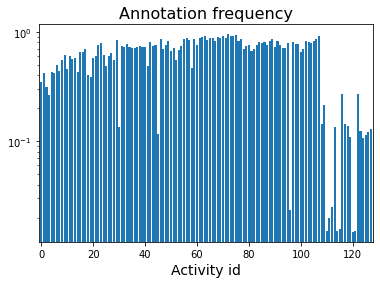

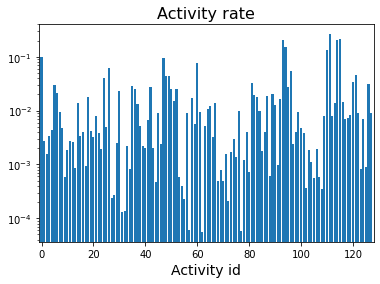

In [ ]:
# The activities we're trying to predict represent severely imbalanced classes; let's get the average rates per
# There are 400k examples to iterate through so we'll make do with a subsample
N = 128
class_counter = np.zeros(N)
annotation_counter = np.zeros(N)
for example_num, graph_stuff in enumerate(dset_train.take(20_000)):
  labels = graph_stuff['labels']
  annotated_inds = np.where(np.isfinite(labels))  ## many activities are not annotated for each molecule; instead there's a nan
  if len(annotated_inds[0]) > 0:  ## this dataset has some examples where every single annotation is nan
    annotated_labels = tf.gather(labels, annotated_inds)
    class_counter[annotated_inds] += annotated_labels
    annotation_counter[annotated_inds] += 1.

activity_rate = class_counter/annotation_counter
annotation_frequency = annotation_counter/float(example_num+1)
for data, title in zip([annotation_frequency, activity_rate], ['Annotation frequency', 'Activity rate']):
  plt.bar(range(N), data)
  plt.xlim(-1, N)
  plt.xlabel('Activity id', fontsize=14)
  plt.title(title, fontsize=16)
  plt.yscale('log')
  plt.show()

In [ ]:
# We'll just try to predict the top activities, to try to avoid the worst of the class imbalance issues
high_activity_inds = np.argsort(activity_rate)[::-1][:10]
high_activity_rates = np.sort(activity_rate)[::-1][:10]
print('Top activity inds:', high_activity_inds)
print('Top activity rates:', high_activity_rates)
print('Top activity annotation rates:', annotation_frequency[high_activity_inds])

Top activity inds: [111 115 114  93  94 110   0  47  60  26]
Top activity rates: [0.26315789 0.21474359 0.20598007 0.20581767 0.15508953 0.13531353
 0.09897265 0.09626242 0.0754643  0.06279591]
Top activity annotation rates: [0.01995 0.0156  0.01505 0.70475 0.71765 0.01515 0.34555 0.69965 0.7646
 0.60195]


In [ ]:
# Let's just use the first, and create a balanced training dataset for it by filtering into two datasets,
# one where the molecules are always active and the other where they're always inactive, and then
# shuffling the two datasets together in a 50/50 split
activity_ind_to_predict = high_activity_inds[0]

dset_train_on = dset_train.filter(lambda ex: ex['labels'][activity_ind_to_predict]==1)
dset_train_off = dset_train.filter(lambda ex: ex['labels'][activity_ind_to_predict]==0)
dset_train_balanced = tf.data.experimental.sample_from_datasets([dset_train_on.repeat(), dset_train_off.repeat()])
dset_val_only = dset_validation.filter(lambda ex: tf.math.is_finite(ex['labels'][activity_ind_to_predict]))
dset_test_only = dset_test.filter(lambda ex: tf.math.is_finite(ex['labels'][activity_ind_to_predict]))


Instructions for updating:
Use `tf.data.Dataset.random(...)`.


Instructions for updating:
Use `tf.data.Dataset.random(...)`.


In [ ]:
# We'll use this to manually update in batches, by summing the gradients step by
# step and applying them with the optimizer only after each batch size
# (lot == list of tensors)
def add_lot(lot1, lot2):
  if lot1 == []:
    return lot2
  else:
    return [tf.add(thing1, thing2) for (thing1, thing2) in zip(lot1, lot2)]

In [ ]:
# As a first baseline we'll use a DeepSet network, which discards all edge 
# information, and just feeds the nodes of the network (which is already quite a
# bit of information) as an unordered set
# DeepSet networks should 1) take in arbitrarily many inputs, and 2) be invariant
# to the ordering of the inputs
# To do this we use MLPs and add the order-invariant mean of the feature vecs at
# each layer, and then return the mean at the end
node_description_length = 9

num_units = 128
num_hidden_layers = 8

inp = tfkl.Input((None, node_description_length))
activation_layer = tfkl.LeakyReLU(0.05) 

# From the little chemistry I know, the element number is a good feature for an embedding layer bc we know they're discrete and each could be v different
x_elem, x_else = tf.split(inp, [1, node_description_length-1], axis=-1)
num_elements_ish = 120
element_embedding_dim = 32
x_elem = tfkl.Embedding(num_elements_ish, element_embedding_dim)(tf.cast(x_elem, tf.int32))

x = tf.concat([x_elem[..., 0, :], x_else], -1)
for _ in range(num_hidden_layers):
  x = tfkl.Dense(num_units)(x)
  x += tf.reduce_mean(x, axis=-2, keepdims=True)
  x = activation_layer(x)

x = tf.reduce_mean(x, axis=-2)
x = tfkl.Dense(1)(x)  # predict a logit for the activity

deepset_net = tf.keras.Model(inp, x)

print(deepset_net.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 9)]    0                                            
__________________________________________________________________________________________________
tf.split_2 (TFOpLambda)         [(None, None, 1), (N 0           input_3[0][0]                    
__________________________________________________________________________________________________
tf.cast_2 (TFOpLambda)          (None, None, 1)      0           tf.split_2[0][0]                 
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 1, 32)  3840        tf.cast_2[0][0]                  
____________________________________________________________________________________________

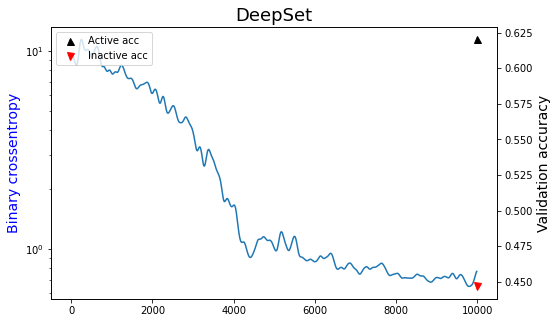

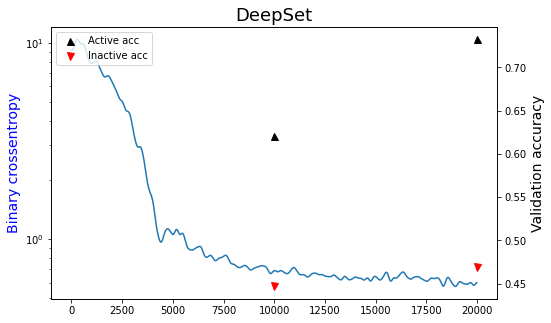

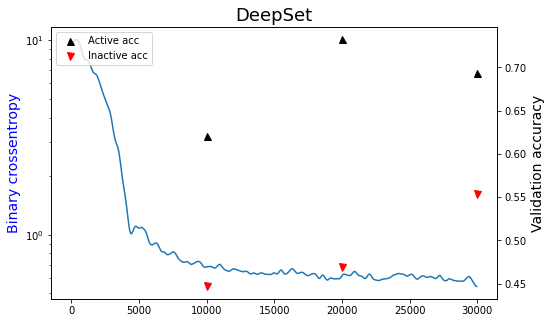

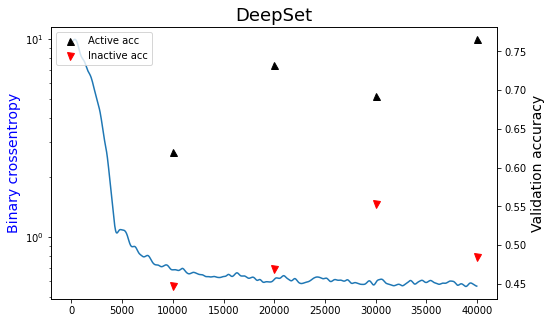

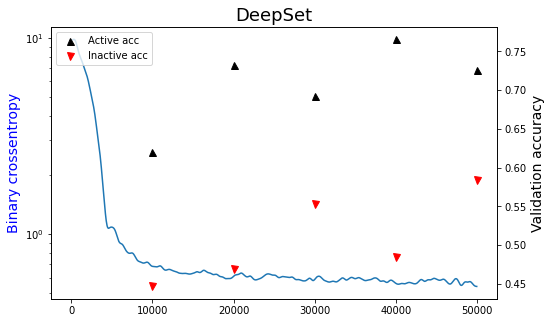

In [ ]:
num_training_steps = 50_000
plot_every = 10_000
bs = 64
lr = 3e-4 / bs  # dividing by batch size because of how we're adding the grads instead of averaging them

########################### TRAINING LOOP ######################################
optimizer = tf.keras.optimizers.Adam(lr)
loss_series = []
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function(experimental_relax_shapes=True)
def train_step(atom_features, labels):
  with tf.GradientTape() as tape:
    prediction = deepset_net(tf.expand_dims(atom_features, 0))
    loss = loss_fn(labels, prediction)
  grads = tape.gradient(loss, deepset_net.trainable_variables)
  return loss, grads

### Training
step_num = 0
losses = []
batch_ind = 0
running_grads = []

val_accs_pos, val_accs_neg = [[], []]

for graph_stuff in dset_train_balanced.shuffle(1_000):
  if step_num > num_training_steps:
    break
  labels = tf.gather(graph_stuff['labels'], [[activity_ind_to_predict]])
  loss, grads = train_step(graph_stuff['node_feat'], labels)
  losses.append(loss.numpy())
  running_grads = add_lot(running_grads, grads)
  batch_ind += 1
  step_num += 1

  if batch_ind == bs:  ## this is our manual batching
    optimizer.apply_gradients(zip(running_grads, deepset_net.trainable_variables))
    running_grads = []
    batch_ind = 0

  if step_num % plot_every == 0:  ## display losses and accuracy on the validation set
    labels, predictions = [[], []]
    for graph_stuff in dset_val_only.take(10000):
      labels.append(tf.gather(graph_stuff['labels'], [activity_ind_to_predict]).numpy()[0])
      predictions.append(deepset_net(tf.expand_dims(graph_stuff['node_feat'], 0))[0].numpy()[0])
    labels = np.float32(labels)
    predictions = np.float32(predictions)
    val_accs_pos.append(np.average((((labels-0.5)*predictions)>0.)[labels==1]))
    val_accs_neg.append(np.average((((labels-0.5)*predictions)>0.)[labels==0]))

    plt.figure(figsize=(8, 5))
    ax = plt.gca()
    ax.plot(range(0, len(losses), len(losses)//1000), nim.filters.gaussian_filter1d(losses, (len(losses)//200))[::(len(losses)//1000)])
    ax2 = ax.twinx()
    ax2.plot(range(0, len(losses)+1, plot_every)[1:], val_accs_pos, 'k^', markersize=7, label='Active acc')
    ax2.plot(range(0, len(losses)+1, plot_every)[1:], val_accs_neg, 'rv', markersize=7, label='Inactive acc')
    plt.legend()
    ax.set_ylabel('Binary crossentropy', color='b', fontsize=14)
    ax2.set_ylabel('Validation accuracy', fontsize=14)
    plt.xlabel('Training step', fontsize=14)
    ax.set_yscale('log')
    plt.title('DeepSet', fontsize=18)
    plt.xlabel('Training step', fontsize=14)
    plt.show()


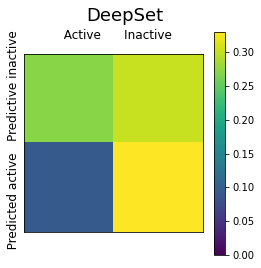

True positive: 0.2726  |  False positive:  0.3032
False negative: 0.0934  |  True negative: 0.3308


In [ ]:
## Evaluate on the test set
labels, predictions = [[], []]
for graph_stuff in dset_test_only:
  labels.append(tf.gather(graph_stuff['labels'], activity_ind_to_predict).numpy())
  predictions.append(deepset_net(tf.expand_dims(graph_stuff['node_feat'], 0))[0].numpy()[0])
labels = np.float32(labels) - 0.5
predictions = np.float32(predictions)
true_positives = np.average(np.logical_and(predictions>0, labels>0))
false_positives = np.average(np.logical_and(predictions>0, labels<0))
true_negatives = np.average(np.logical_and(predictions<0, labels<0))
false_negatives = np.average(np.logical_and(predictions<0, labels>0))

plt.matshow([[true_positives, false_positives],
             [false_negatives, true_negatives]], vmin=0)
plt.title('  Active      Inactive', fontsize=12)
plt.ylabel('  Predicted active   Predictive inactive', fontsize=12)
plt.xticks([]); plt.yticks([])
plt.colorbar()
plt.suptitle('DeepSet', y=0.95, fontsize=18)
plt.show()
print(f'True positive: {true_positives:.4f}  |  False positive:  {false_positives:.4f}')
print(f'False negative: {false_negatives:.4f}  |  True negative: {true_negatives:.4f}')

In [ ]:
# Step 2: Use the connectivity information (which nodes are connected to which)
# We'll follow graph convolutional networks (GCNs) a la Kipf and Welling 2016
# where the node information is passed along to all neighbors and aggregated by
# summing. 
# An important parameter is the number of iterations of message passing, which
# determines the number of hops information is able to travel
num_recurrences = 4
node_description_length = 9

act_fn = tfkl.LeakyReLU(0.05) 
enc_spec = [128]*1
encoder_node = tf.keras.Sequential([tfkl.Dense(num_units, act_fn) for num_units in enc_spec])

prop_units = 128

dec_spec = [128]*1
prediction_size = num_to_predict
decoder_node = tf.keras.Sequential([tfkl.Dense(num_units, act_fn) for num_units in dec_spec] + [tfkl.Dense(1)])

inp_nodes = tf.keras.Input(type_spec=tf.TensorSpec((None, node_description_length), dtype=tf.float32))
inp_edge_connections = tf.keras.Input(type_spec=tf.TensorSpec((None, 2), dtype=tf.int32))

# Turn the atomic numbers into learned embeddings as before
x_elem, x_else = tf.split(inp_nodes, [1, node_description_length-1], axis=-1)
num_elements_ish = 120
element_embedding_dim = 8
x_elem = tfkl.Embedding(num_elements_ish, element_embedding_dim)(tf.cast(x_elem, tf.int32))
x = tf.concat([x_elem[..., 0, :], x_else], -1)

num_nodes = tf.shape(inp_nodes)[0]  # We need this for one of the reduction operations during message passing
num_edges = tf.shape(inp_edge_connections)[0]  # We need this for the degrees

intermed_nodes = encoder_node(x)

degree_per_node = tf.math.unsorted_segment_sum(tf.ones(num_edges), inp_edge_connections[..., 0], num_nodes)
degree_per_node += tf.math.unsorted_segment_sum(tf.ones(num_edges), inp_edge_connections[..., 1], num_nodes)
degree_per_node += 1
degree_per_node = tf.cast(degree_per_node, tf.float32)
degree_per_node = tf.expand_dims(degree_per_node, -1)

## Propagate
for i in range(num_recurrences):
  nodes1 = tf.gather(intermed_nodes, inp_edge_connections[..., 0])  # the nodes at the start of the edge;
  aggregated_nodes = tf.math.unsorted_segment_sum(nodes1, inp_edge_connections[..., 1], num_nodes)  # Aggregate all those nodes to the other edge
  nodes2 = tf.gather(intermed_nodes, inp_edge_connections[..., 1])  # repeat the other way
  aggregated_nodes += tf.math.unsorted_segment_sum(nodes2, inp_edge_connections[..., 0], num_nodes)
  # add the self connection
  aggregated_nodes += intermed_nodes

  # divide by the degree; they do something a little spicier in the GCN paper but this should get the gist of it
  aggregated_nodes /= degree_per_node

  # Finally pass this through a learned dense layer
  intermed_nodes = tfkl.Dense(prop_units, act_fn)(aggregated_nodes)

# Reduce the graph with some reduction function over nodes
reduced_graph = tf.reduce_mean(intermed_nodes, axis=-2, keepdims=True)  # we have to keepdims so that tensorflow is fine with the ranks of the tensors
decoded_nodes = decoder_node(reduced_graph)  # finally, decode this high dimensional vector into something we care about: logit of whether the molecule has the particular activity

gcn = tf.keras.Model([inp_nodes, inp_edge_connections], decoded_nodes)
print(gcn.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
tf.split_3 (TFOpLambda)         [(None, 1), (None, 8 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf.cast_3 (TFOpLambda)          (None, 1)            0           tf.split_3[0][0]                 
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 2)]          0                                            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/tf.compat.v1.gather_6/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_3/tf.compat.v1.gather_6/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model_3/tf.compat.v1.gather_6/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_3/tf.compat.v1.gather_7/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_3/tf.compat.v1.gather_7/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model_3/

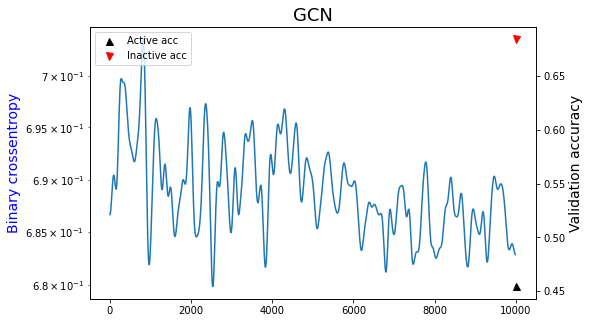

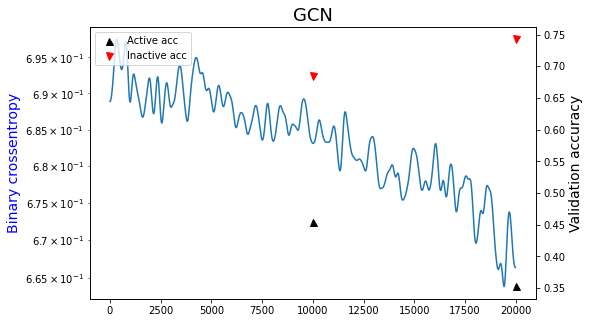

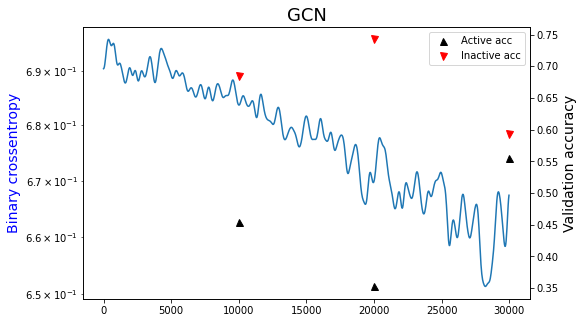

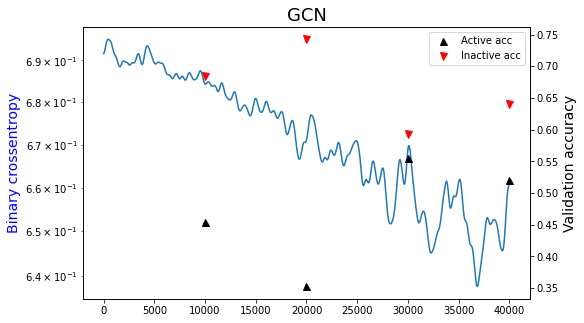

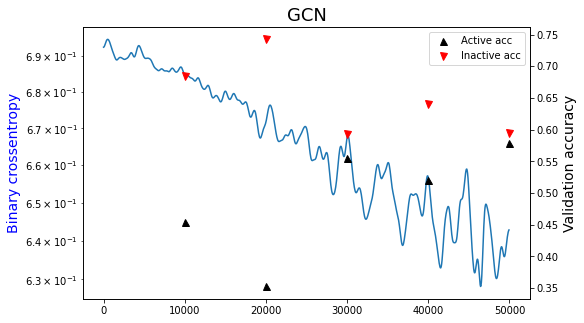

In [ ]:
num_training_steps = 50_000
plot_every = 10_000
bs = 32
lr = 3e-4 / bs

########################### TRAINING LOOP ######################################
optimizer = tf.keras.optimizers.Adam(lr)
loss_series = []
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function(experimental_relax_shapes=True)
def train_step(atom_features, bond_indices, labels):
  with tf.GradientTape() as tape:
    prediction = gcn([atom_features, bond_indices])
    loss = loss_fn(labels, prediction)
  grads = tape.gradient(loss, gcn.trainable_variables)
  return loss, grads

### Training
step_num = 0
losses = []
batch_ind = 0
running_grads = []

val_accs_pos, val_accs_neg = [[], []]

for graph_stuff in dset_train_balanced.shuffle(1_000):
  if step_num > num_training_steps:
    break
  labels = tf.gather(graph_stuff['labels'], [activity_ind_to_predict])
  loss, grads = train_step(graph_stuff['node_feat'], graph_stuff['edge_index'], labels)
  losses.append(loss.numpy())
  running_grads = add_lot(running_grads, grads)
  batch_ind += 1
  step_num += 1

  if batch_ind == bs:  ## manual batching
    optimizer.apply_gradients(zip(running_grads, gcn.trainable_variables))
    running_grads = []
    batch_ind = 0

  if step_num % plot_every == 0:  ## losses and validation set eval
    labels, predictions = [[], []]
    for graph_stuff in dset_val_only.take(10_000):
      labels.append(tf.gather(graph_stuff['labels'], [activity_ind_to_predict]).numpy()[0])
      predictions.append(gcn([graph_stuff['node_feat'], graph_stuff['edge_index']])[0].numpy()[0])
    labels = np.float32(labels)
    predictions = np.float32(predictions)
    val_accs_pos.append(np.average((((labels-0.5)*predictions)>0.)[labels==1]))
    val_accs_neg.append(np.average((((labels-0.5)*predictions)>0.)[labels==0]))

    plt.figure(figsize=(8, 5))
    ax = plt.gca()
    ax.plot(range(0, len(losses), len(losses)//1000), nim.filters.gaussian_filter1d(losses, (len(losses)//200))[::(len(losses)//1000)])
    ax2 = ax.twinx()
    ax2.plot(range(0, len(losses)+1, plot_every)[1:], val_accs_pos, 'k^', markersize=7, label='Active acc')
    ax2.plot(range(0, len(losses)+1, plot_every)[1:], val_accs_neg, 'rv', markersize=7, label='Inactive acc')
    plt.legend()
    ax.set_ylabel('Binary crossentropy', color='b', fontsize=14)
    ax2.set_ylabel('Validation accuracy', fontsize=14)
    plt.xlabel('Training step', fontsize=14)
    ax.set_yscale('log')
    plt.title('GCN', fontsize=18)
    plt.xlabel('Training step', fontsize=14)
    plt.show()


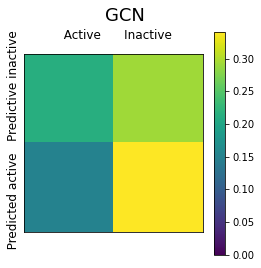

True positive: 0.2144  |  False positive:  0.2928
False negative: 0.1516  |  True negative: 0.3412


In [ ]:
labels, predictions = [[], []]
for graph_stuff in dset_test_only:
  labels.append(tf.gather(graph_stuff['labels'], activity_ind_to_predict).numpy())
  predictions.append(gcn([graph_stuff['node_feat'], graph_stuff['edge_index']])[0].numpy()[0])
labels = np.float32(labels) - 0.5
predictions = np.float32(predictions)
true_positives = np.average(np.logical_and(predictions>0, labels>0))
false_positives = np.average(np.logical_and(predictions>0, labels<0))
true_negatives = np.average(np.logical_and(predictions<0, labels<0))
false_negatives = np.average(np.logical_and(predictions<0, labels>0))

plt.matshow([[true_positives, false_positives],
             [false_negatives, true_negatives]], vmin=0)
plt.title('  Active      Inactive', fontsize=12)
plt.ylabel('  Predicted active   Predictive inactive', fontsize=12)
plt.xticks([]); plt.yticks([])
plt.colorbar()
plt.suptitle('GCN', y=0.95, fontsize=18)
plt.show()
print(f'True positive: {true_positives:.4f}  |  False positive:  {false_positives:.4f}')
print(f'False negative: {false_negatives:.4f}  |  True negative: {true_negatives:.4f}')

In [ ]:
# Now let's also incorporate the information in the edges (e.g. about the bond type), 
# following a DeepMind paper on glassy systems (Bapst 2020)
# To make a network which uses this info an allows for arbitrary graphs, we
# do 2 stages of message passing, first updating the edges with info from the 
# nodes on either side, and then updating the nodes with info from all incoming
# edges.  At the beginning and end, we need to encode the raw inputs and decode
# the feature vectors to meaningful outputs, making for a total of 5 different
# networks (encoder for edges, encoder for nodes, updater for edges, updater for
# nodes, decoder for network).  We'll use MLPs for all of them

num_recurrences = 6

act_fn = tfkl.LeakyReLU(0.05) 
enc_spec = [128]*1
encoder_edge = tf.keras.Sequential([tfkl.Dense(num_units, act_fn) for num_units in enc_spec])
encoder_node = tf.keras.Sequential([tfkl.Dense(num_units, act_fn) for num_units in enc_spec])

prop_spec_edge = [128]*2
prop_spec_node = [128]*2
propagator_edge = tf.keras.Sequential([tfkl.Dense(num_units, act_fn) for num_units in prop_spec_edge])
propagator_node = tf.keras.Sequential([tfkl.Dense(num_units, act_fn) for num_units in prop_spec_node])

dec_spec = [128]*1
decoder_node = tf.keras.Sequential([tfkl.Dense(num_units, act_fn) for num_units in dec_spec] + [tfkl.Dense(1)])

# Now hook the networks together, in a similar way to the GCN for step 2
node_description_length = 9
edge_description_length = 3

inp_nodes = tf.keras.Input(type_spec=tf.TensorSpec((None, node_description_length), dtype=tf.float32))

x_elem, x_else = tf.split(inp_nodes, [1, node_description_length-1], axis=-1)
num_elements_ish = 120
element_embedding_dim = 8
x_elem = tfkl.Embedding(num_elements_ish, element_embedding_dim)(tf.cast(x_elem, tf.int32))

x = tf.concat([x_elem[..., 0, :], x_else], -1)

inp_edges = tf.keras.Input(type_spec=tf.TensorSpec((None, edge_description_length), dtype=tf.float32))
inp_edge_connections = tf.keras.Input(type_spec=tf.TensorSpec((None, 2), dtype=tf.int32))

num_nodes = tf.shape(inp_nodes)[0]

intermed_edges = encoder_edge(inp_edges)  # we'll make skip connections so the original encodings are involved in every message passing
intermed_nodes = encoder_node(x)

out_edges = intermed_edges
out_nodes = intermed_nodes
## Propagate
for _ in range(num_recurrences):
  nodes1 = tf.gather(out_nodes, inp_edge_connections[..., 0])  # the nodes at the start of the edge;
  nodes2 = tf.gather(out_nodes, inp_edge_connections[..., 1])  # the nodes at the end of the edge;
  collected_nodes_per_edge = tf.concat([nodes1, nodes2], axis=-1)
  collected_edges_per_node = tf.math.unsorted_segment_mean(out_edges, inp_edge_connections[..., 0], num_nodes)  # Add all the edges that emanate from a particular node
  collected_edges_per_node += tf.math.unsorted_segment_mean(out_edges, inp_edge_connections[..., 1], num_nodes)  # And don't forget the edges that 'end' at that node
  
  out_nodes = propagator_node(tf.concat([intermed_nodes, out_nodes, collected_edges_per_node], -1))
  out_edges = propagator_edge(tf.concat([intermed_edges, out_edges, collected_nodes_per_edge], -1))

# Reduce the graph with some reduction fn over nodes
reduced_graph = tf.reduce_mean(out_nodes, axis=-2, keepdims=True)  # we have to keepdims so that tensorflow is fine with the ranks of the tensors
decoded_nodes = decoder_node(reduced_graph)  # finally, decode this high dimensional vector into something we care about: probabilities of whether the molecule has the particular activities

full_graph_model = tf.keras.Model([inp_nodes, inp_edges, inp_edge_connections], decoded_nodes)
print(full_graph_model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
tf.split_4 (TFOpLambda)         [(None, 1), (None, 8 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf.cast_5 (TFOpLambda)          (None, 1)            0           tf.split_4[0][0]                 
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 8)         960         tf.cast_5[0][0]                  
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/tf.compat.v1.gather_16/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_4/tf.compat.v1.gather_16/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/model_4/tf.compat.v1.gather_16/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_4/tf.compat.v1.gather_17/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_4/tf.compat.v1.gather_17/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/mod

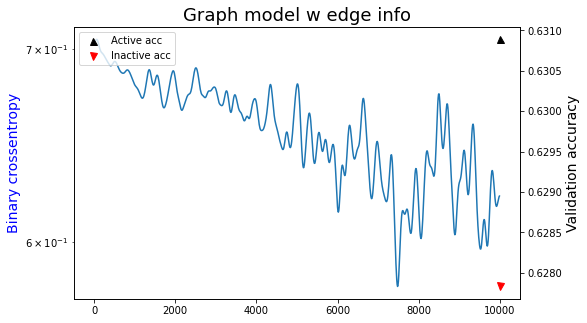

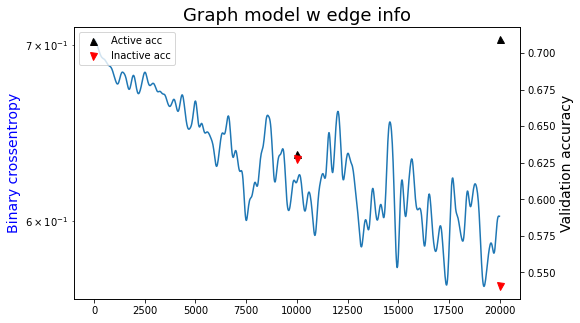

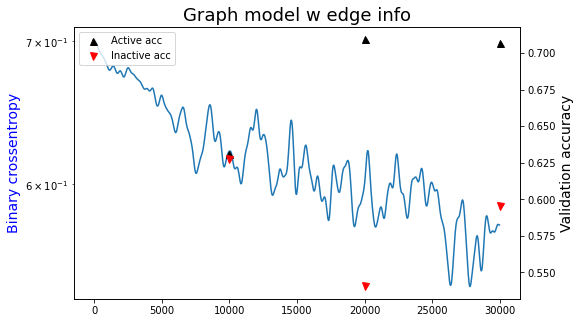

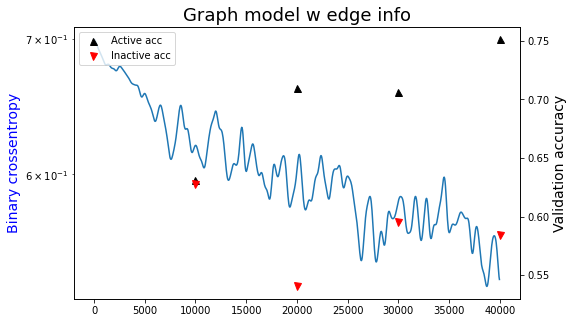

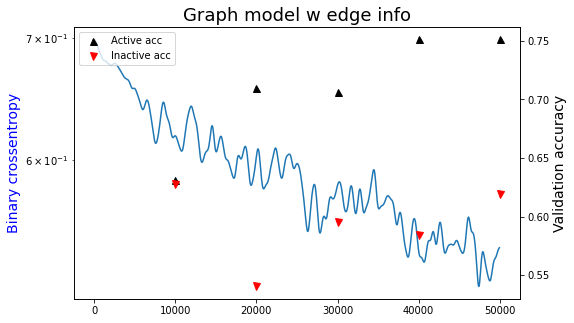

In [25]:
num_training_steps = 50_000
plot_every = 10_000
bs = 64
lr = 3e-3 / bs

########################### TRAINING LOOP ######################################
optimizer = tf.keras.optimizers.Adam(lr)
loss_series = []
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function(experimental_relax_shapes=True)
def train_step(atom_features, bond_info, bond_indices, labels):
  with tf.GradientTape() as tape:
    prediction = full_graph_model([atom_features, bond_info, bond_indices])
    loss = loss_fn(labels, prediction)
  grads = tape.gradient(loss, full_graph_model.trainable_variables)
  return loss, grads

### Training
step_num = 0
losses = []
batch_ind = 0
running_grads = []

dset_train_on = dset_train.filter(lambda ex: ex['labels'][activity_ind_to_predict]==1)
dset_train_off = dset_train.filter(lambda ex: ex['labels'][activity_ind_to_predict]==0)
dset_train_balanced = tf.data.experimental.sample_from_datasets([dset_train_on.repeat(), dset_train_off.repeat()])
val_accs_pos, val_accs_neg = [[], []]
dset_val_only = dset_validation.filter(lambda ex: tf.math.is_finite(ex['labels'][activity_ind_to_predict]))

for graph_stuff in dset_train_balanced.shuffle(10000):
  if step_num > num_training_steps:
    break
  labels = tf.gather(graph_stuff['labels'], [activity_ind_to_predict])
  loss, grads = train_step(graph_stuff['node_feat'], graph_stuff['edge_feat'], graph_stuff['edge_index'], labels)
  losses.append(loss.numpy())
  running_grads = add_lot(running_grads, grads)
  batch_ind += 1
  step_num += 1

  if batch_ind == bs:  ## manual batching
    optimizer.apply_gradients(zip(running_grads, full_graph_model.trainable_variables))
    running_grads = []
    batch_ind = 0

  if step_num % plot_every == 0:  ## display losses and validation accuracy
    labels, predictions = [[], []]
    for graph_stuff in dset_val_only.take(1_000):
      labels.append(tf.gather(graph_stuff['labels'], [activity_ind_to_predict]).numpy()[0])
      predictions.append(full_graph_model([graph_stuff['node_feat'], 
                                           graph_stuff['edge_feat'],
                                           graph_stuff['edge_index']])[0].numpy()[0])
    labels = np.float32(labels)
    predictions = np.float32(predictions)
    val_accs_pos.append(np.average((((labels-0.5)*predictions)>0.)[labels==1]))
    val_accs_neg.append(np.average((((labels-0.5)*predictions)>0.)[labels==0]))

    plt.figure(figsize=(8, 5))
    ax = plt.gca()
    ax.plot(range(0, len(losses), len(losses)//1000), nim.filters.gaussian_filter1d(losses, (len(losses)//200))[::(len(losses)//1000)])
    ax2 = ax.twinx()
    ax2.plot(range(0, len(losses)+1, plot_every)[1:], val_accs_pos, 'k^', markersize=7, label='Active acc')
    ax2.plot(range(0, len(losses)+1, plot_every)[1:], val_accs_neg, 'rv', markersize=7, label='Inactive acc')
    plt.legend()
    ax.set_ylabel('Binary crossentropy', color='b', fontsize=14)
    ax2.set_ylabel('Validation accuracy', fontsize=14)
    plt.xlabel('Training step', fontsize=14)
    ax.set_yscale('log')
    plt.title('Graph model w edge info', fontsize=18)
    plt.xlabel('Training step', fontsize=14)
    plt.show()


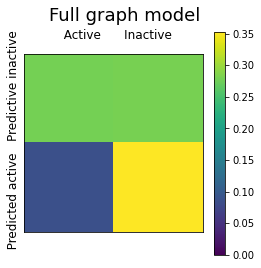

True positive: 0.2795  |  False positive:  0.2807
False negative: 0.0865  |  True negative: 0.3533


In [26]:
labels, predictions = [[], []]
for graph_stuff in dset_test_only:
  labels.append(tf.gather(graph_stuff['labels'], activity_ind_to_predict).numpy())
  predictions.append(full_graph_model([graph_stuff['node_feat'], 
                                       graph_stuff['edge_feat'],
                                       graph_stuff['edge_index']])[0].numpy()[0])
labels = np.float32(labels) - 0.5
predictions = np.float32(predictions)
true_positives = np.average(np.logical_and(predictions>0, labels>0))
false_positives = np.average(np.logical_and(predictions>0, labels<0))
true_negatives = np.average(np.logical_and(predictions<0, labels<0))
false_negatives = np.average(np.logical_and(predictions<0, labels>0))

plt.matshow([[true_positives, false_positives],
             [false_negatives, true_negatives]], vmin=0)
plt.title('  Active      Inactive', fontsize=12)
plt.ylabel('  Predicted active   Predictive inactive', fontsize=12)
plt.xticks([]); plt.yticks([])
plt.colorbar()
plt.suptitle('Full graph model', y=0.95, fontsize=18)
plt.show()
print(f'True positive: {true_positives:.4f}  |  False positive:  {false_positives:.4f}')
print(f'False negative: {false_negatives:.4f}  |  True negative: {true_negatives:.4f}')